In [2]:
# CSC478 Final Project Application Part 1
import os
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Load movieLens data
path = os.getcwd()+'/Movielens'
os.chdir(path)
users = pd.read_table('u.user',delimiter='|',header=None,names=["id","age","gender","job","zip code"])
movies = pd.read_table('u.item',delimiter='|',header=None, names=["id","title","rl_date","vrl_date","url",
                                                                 "unknown","Action","Adventure","Animation",
                                                                 "Children's","Comedy","Crime","Documentary",
                                                                 "Drama","Fantasy","Film-Noir","Horror",
                                                                 "Musical","Mystery","Romance","Sci-Fi",
                                                                 "Thriller","War","Western"])
ratings = pd.read_table('u.data',delimiter='\t',header=None,names=["user","movie","rating","timestamp"])
genres = pd.read_table('u.genre',delimiter='|',header=None,names=["genre","id"])

In [4]:
# Project Part 2 Movie Recommender System
rating_mat=np.zeros((len(users),len(movies)))
rating_mat.shape

(943, 1682)

In [27]:
# Convert rating list to user-movie rating matrix
for i in range(len(ratings)):
    user=int(ratings.user[i])-1
    movie=int(ratings.movie[i])-1
    rating=int(ratings.rating[i])
    rating_mat[user,movie]=rating

In [28]:
# user * movie rating matrix
rating_mat

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [42]:
# Some utility function
def cosSim(vecA,vecB):
    return np.dot(vecA, vecB) / ( np.linalg.norm(vecA) * np.linalg.norm(vecB) )

def cosDist(vecA,vecB):
    return 1 - np.dot(vecA, vecB) / ( np.linalg.norm(vecA) * np.linalg.norm(vecB) )

def userProfile(userId):
    
    gender = "male" if users.gender[userId] == "M" else "female"
    print "\nUser " + str(userId+1) + " is " + str(users.age[userId]) + " years old " + gender + \
    ", occupation: " + users.job[userId] + "."
    
    # Get the movie ids of top 5 highest rating.
    movieIds = np.argsort(rating_mat[userId,:])[-5:]
    
    # Print user's top 5 favorite movies
    print "\nUser" + str(userId+1) + "'s top 5 favorite movies are:"
    for i in movieIds:
        print movies.title[i] 
        
def unratedMovies(userId):
    unrated = []
    for i in range(len(movies)):
        if rating_mat[userId,i] == 0:
            unrated.append(i)
    return unrated

In [43]:
# Test cosSim
print "Similarity of user1 and user2 is " + str(cosSim(rating_mat[0,:],rating_mat[1,:]))

# Test userProfile
userProfile(0)
userProfile(1)

# Test unratedMovies
print "\nUser1 has not rated " + str(len(movies)-len(unratedMovies(0))) + " movies."

Similarity of user1 and user2 is 0.166930983869

User 1 is 24 years old male, occupation: technician.

User1's top 5 favorite movies are:
Raiders of the Lost Ark (1981)
Princess Bride, The (1987)
Empire Strikes Back, The (1980)
Alien (1979)
Toy Story (1995)

User 2 is 53 years old female, occupation: other.

User2's top 5 favorite movies are:
Shall We Dance? (1996)
Sense and Sensibility (1995)
Star Wars (1977)
L.A. Confidential (1997)
Emma (1996)

User1 has not rated 272 movies.


In [31]:
# Normalization
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler().fit(rating_mat)
rating_mat_norm = min_max_scaler.transform(rating_mat)
rating_mat_norm

array([[ 1. ,  0.6,  0.8, ...,  0. ,  0. ,  0. ],
       [ 0.8,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       ..., 
       [ 1. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. , ...,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. , ...,  0. ,  0. ,  0. ]])

In [44]:
# kNN predict
def kNNPredict(data,k,userId,movieId,distMea=cosDist):
    dists = []
    index = []
    for i in range(len(users)):
        if i != userId and data[i,movieId] != 0:
            dists.append(distMea(data[userId,:],data[i,:]))
            index.append(i)

    topKIndex = np.argsort(dists)[:k]
    
    rating = 0    
    for i in topKIndex:
        rating += data[index[i],movieId]
    rating = int(round(rating/len(topKIndex)))
    return rating

def kNNErrStat(data,uList,mList,k):
    errCnt = 0
    totCnt = 0
    errRate = 0
    err = 0
    rsme = 0

    for i in uList:
        for j in mList:
            pred = kNNPredict(data,k,i,j)
            actl = int(data[i-1,j-1])
            if actl != 0:
                totCnt += 1
                if pred != actl:
                    errCnt += 1
                    err += (actl-pred)*(actl-pred)
            # print "user" + str(i) +"/" + movies.title[j] + " prediction : " + str(pred) + " vs actual: " + str(actl)
    rmse = np.sqrt(err/totCnt)
    errRate = errCnt/float(totCnt)
    print "the total error rate with k=%d is: %f, rmse is %f" % (k,errRate,rmse)
    return errRate,rmse

In [33]:
errsList = []
rmseList = []
uList = list(range(1,11))
mList = list(range(1,21))
k = range(1,51,5)

for i in k:
    err, rmse = kNNErrStat(rating_mat,uList,mList,i)
    errsList.append(err)
    rmseList.append(rmse)

the total error rate with k=1 is: 0.807018, rmse is 1.414214
the total error rate with k=6 is: 0.719298, rmse is 1.000000
the total error rate with k=11 is: 0.684211, rmse is 1.000000
the total error rate with k=16 is: 0.649123, rmse is 1.000000
the total error rate with k=21 is: 0.684211, rmse is 1.000000
the total error rate with k=26 is: 0.701754, rmse is 1.000000
the total error rate with k=31 is: 0.701754, rmse is 1.000000
the total error rate with k=36 is: 0.684211, rmse is 1.000000
the total error rate with k=41 is: 0.701754, rmse is 1.000000
the total error rate with k=46 is: 0.684211, rmse is 1.000000


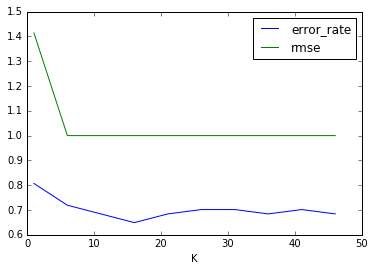

In [34]:
%matplotlib inline
plt.plot(k, errsList, label='error rate')
plt.plot(k, rmseList, label='rmse')
plt.legend(('error_rate', 'rmse'))
plt.xlabel('K')
plt.show()

In [45]:
# The best k is 46, the error rate and rmse goes down as the k increases.